# Atividade 1 da Disciplica de Machine Learning
## Alunos: Gabriel Miranda, Rafael Takeguma, Arthur Santos
## Etapa 1: Pré-processamento dos dados

Abrindo o dataset em um dataframe pandas

In [5]:
import pandas as pd

df = pd.read_csv("dataset - dataset.csv")
df.head()

,curriculum_id,student_id,centro,department_name,course_name,student_age_at_initial_period,birthday,birth_place,ingress_form,locks_number,...,optative_ch_progress,curriculum_status,leaving_reason,mc,course_mc,iepl,course_iepl,iech,course_iech,iea
0,122,97,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,30,1964-05-14,PORTO ALEGRE/RS,TRANSFERÊNCIA COMPULSÓRIA,0,...,100,CANCELADO,DECURSO DE PRAZO MÁXIMO P/ CONCLUSÃO DE CURSO,1.79,4.537.049.312.853.680,0.3,476.704.122.877.932,0.3,5.301.382.376.717.860,1.611
1,215,167,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,18,1980-05-11,ARACAJU/SE,VESTIBULAR,0,...,100,CANCELADO,ABANDONO,6.69,4.537.049.312.853.680,0.3,476.704.122.877.932,367.0,5.301.382.376.717.860,7.366
2,348,285,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,19,1983-10-26,ARACAJU/SE,VESTIBULAR,0,...,100,CANCELADO,ABANDONO,6.66,4.537.049.312.853.680,0.3,476.704.122.877.932,446.0,5.301.382.376.717.860,8.911
3,352,289,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,21,1981-08-08,RIO DE JANEIRO/RJ,VESTIBULAR,0,...,100,CANCELADO,ABANDONO,6.71,4.537.049.312.853.680,0.3,476.704.122.877.932,411.0,5.301.382.376.717.860,8.273
4,414,351,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,18,1986-02-10,ARACAJU/SE,VESTIBULAR,0,...,100,CONCLUÍDO,CONCLUÍDO,6.55,4.537.049.312.853.680,325.0,476.704.122.877.932,429.0,5.301.382.376.717.860,9.132


In [7]:
# Exibe informações gerais sobre o dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2603 entries, 0 to 2602
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   curriculum_id                  2603 non-null   int64  
 1   student_id                     2603 non-null   int64  
 2   centro                         2603 non-null   object 
 3   department_name                2603 non-null   object 
 4   course_name                    2603 non-null   object 
 5   student_age_at_initial_period  2603 non-null   int64  
 6   birthday                       2603 non-null   object 
 7   birth_place                    2600 non-null   object 
 8   ingress_form                   2603 non-null   object 
 9   locks_number                   2603 non-null   int64  
 10  required_ch_progress           2603 non-null   object 
 11  optative_ch_progress           2603 non-null   object 
 12  curriculum_status              2603 non-null   o

In [ ]:
# Exibe as colunas numéricas do dataset
df.describe()

,curriculum_id,student_id,student_age_at_initial_period,locks_number,mc,iepl,iech,iea
count,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000
mean,2550.522474,2264.339608,21.346523,0.189013,4.591375,312.472714,346.771913,46.071515
std,869.011702,819.279402,4.983348,0.451748,2.577844,325.345983,346.864085,156.170263
min,122.000000,55.000000,16.000000,0.000000,0.000000,0.300000,0.300000,0.000000
25%,1920.500000,1642.500000,18.000000,0.000000,2.670000,0.300000,0.300000,1.736700
50%,2627.000000,2332.000000,19.000000,0.000000,5.090000,335.000000,355.000000,3.371900
75%,3278.500000,2945.500000,22.000000,0.000000,6.680000,589.000000,662.000000,5.950800
max,3925.000000,3589.000000,54.000000,3.000000,10.000000,997.000000,991.000000,999.000000


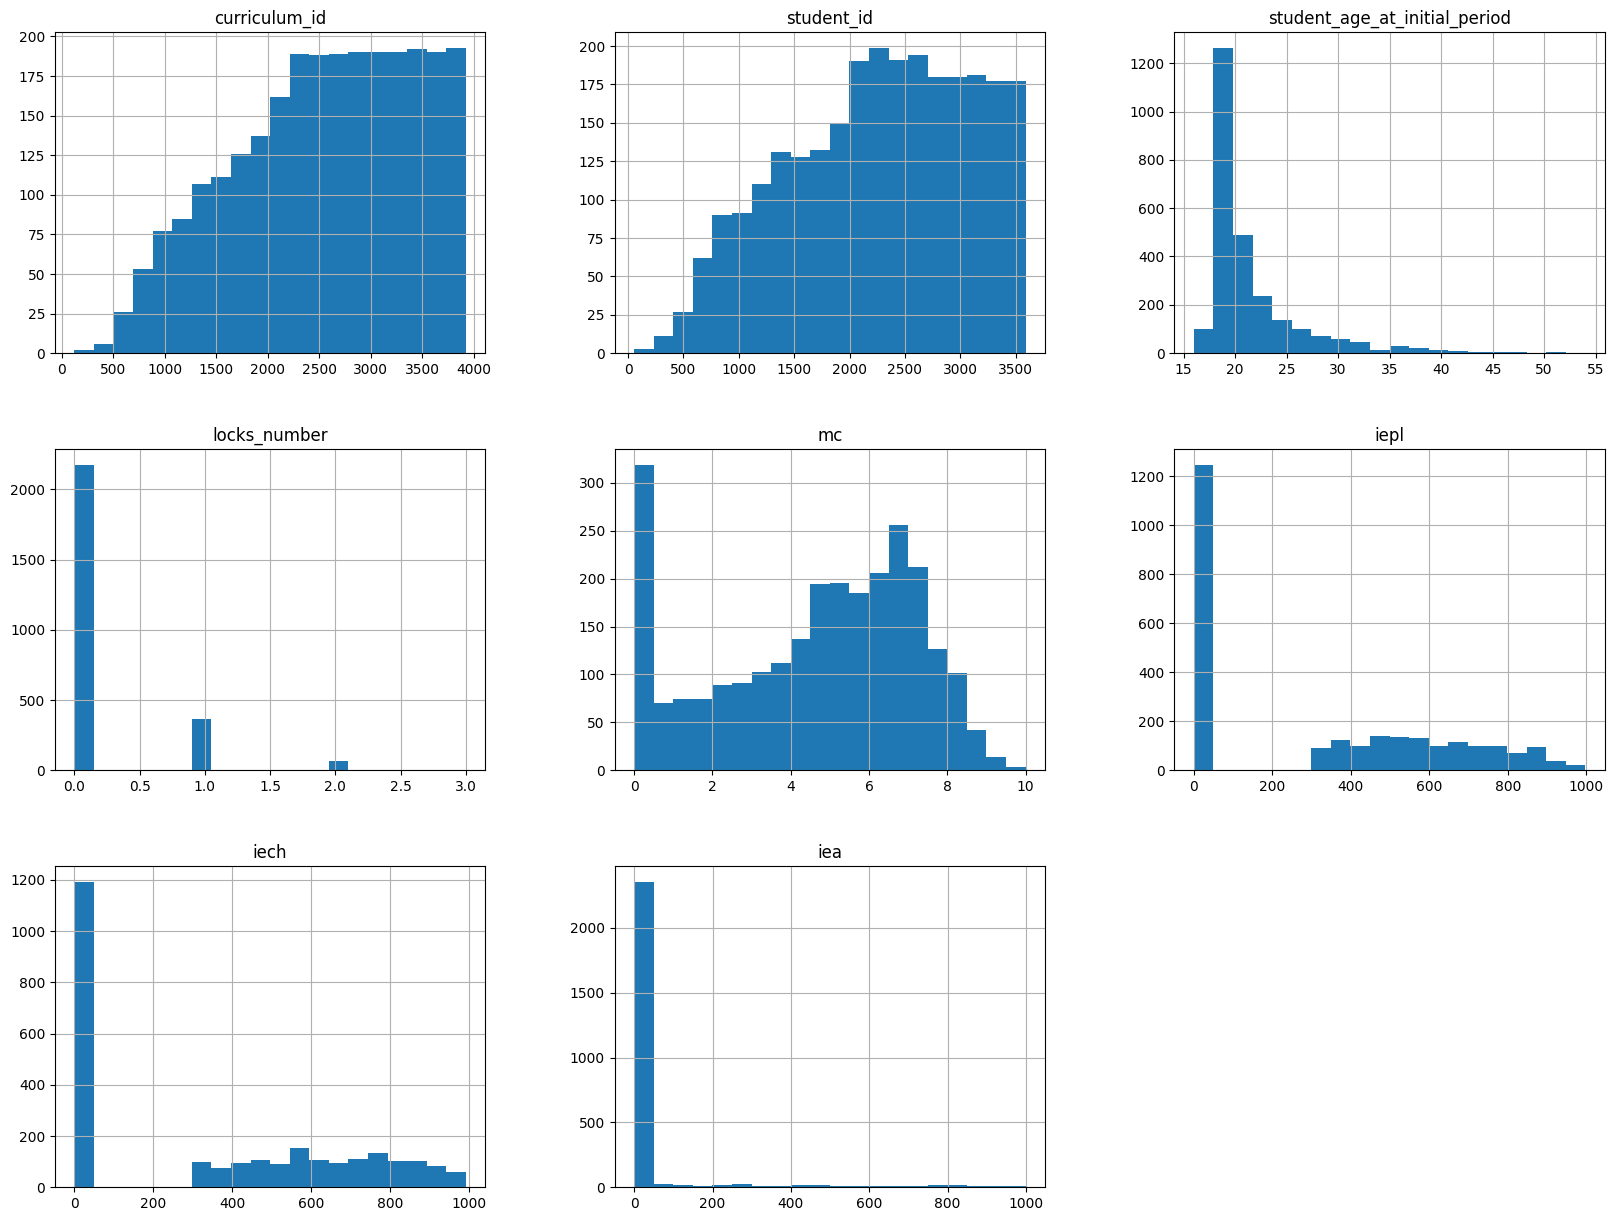

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

df.hist(bins=20, figsize=(20,15))
plt.show()

Primeiro, será realizada uma "poda" inicial dos dados, removendo colunas que não representam correlação com a evasão do curso

In [ ]:
df = df.